In [1]:
from PV_Functions import generate_cross_section
from Laplacian_Functions_torch import *
import networkx

from sklearn.cluster import DBSCAN

from tdamapper.learn import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperPlot

from tdamapper._plot_plotly import aggregate_graph
from landscapes import Landscape, Lap_Landscape

import pickle
import os
import os.path as osp

from PV_Functions import generate_cross_section_centers
import gudhi 

from pyballmapper import BallMapper
from pyballmapper.plotting import kmapper_visualize
from plot_complex import draw_filtration

def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    # return B22_sm1t@B22_stm1-B22_st
    return B22_stm1 - B22_st - B22_sm1tm1 + B22_sm1t

In [2]:
def graph_filtration(graph, node_to_color):
    simplices = []
    # points_covered_by_landmarks = bm.points_covered_by_landmarks
    # print(points_covered_by_landmarks)
    # # print(reversed(list(networkx.enumerate_all_cliques(bm.Graph))))
    # node_to_color = {node_i: np.mean([y_1[point_i] for point_i in points_covered_by_landmarks[node_i]]) for node_i in points_covered_by_landmarks.keys()}
    nodes_done = set()
    simplex_to_nodes = {}
    nodes_to_simplex = {node_i: node_i for node_i in graph.nodes}
    for c in reversed(list(networkx.enumerate_all_cliques(graph))):
        if any([i in nodes_done for i in c]) and len(c) > 2:
            continue
        elif len(c) > 2:
            nodes_done.update(c)

            for i in c:
                nodes_to_simplex[i] = min(c)
            simplices.append(([min(c)], np.mean([node_to_color[i] for i in c])))
            simplex_to_nodes[min(c)] = c
        elif len(c) == 2:
            if c[0] not in nodes_done:
                simplex_to_nodes[c[0]] = [c[0]]
                simplices.append(([c[0]], node_to_color[c[0]]))
                nodes_done.add(c[0])
            if c[1] not in nodes_done:
                simplex_to_nodes[c[1]] = [c[1]]
                simplices.append(([c[1]], node_to_color[c[1]]))
                nodes_done.add(c[1])
            if nodes_to_simplex[c[0]] != nodes_to_simplex[c[1]]:
                avg_0 = np.mean([node_to_color[i] for i in simplex_to_nodes[nodes_to_simplex[c[0]]]])
                avg_1 = np.mean([node_to_color[i] for i in simplex_to_nodes[nodes_to_simplex[c[1]]]])
                simplices.append(([nodes_to_simplex[c[0]], nodes_to_simplex[c[1]]], np.max([avg_0, avg_1])))

    # for s in simplex_to_nodes.keys():
    #     simplices.append([s], np.mean([node_to_color[i] for i in simplex_to_nodes[s]]))

        # if len(c) <= 2:
        # simplices.append((c, np.max([node_to_color[i] for i in c])))

    f = dio.Filtration()
    max_time = 0
    for vertices, time in simplices:
        f.append(dio.Simplex(vertices, time))
        max_time = max(max_time, time)
    f.sort()

    return f, simplex_to_nodes, nodes_to_simplex

def filtration_from_image_ballmapper(image = None, np_array = None, background_value = None, 
                          eps=None, save_to_html=None, use_y_as_color=False, use_x_as_color = False, use_new_filtration=False):
    """
    Create a filtration from an image by removing the background and applying Mapper.
    The image should be a PIL Image object.

    Parameters:
    image (PIL.Image): The input image to process.
    background_value: The value to consider as background (optional). If None, it will be calculated as the mean of the image.
    eps (float): The epsilon value for the BallMapper. If None, images_size/80 will be used.
    save_to_html (str): If provided, the resulting Mapper will be saved to an HTML file at this path.
    """

    # Convert the image to a grayscale numpy array
    if image is not None:
        im_gray = 1-np.array(image.convert("L")).astype(int)/255
    else:
        im_gray = np_array

    # Remove the background
    if background_value is None:
        background_value = np.mean(im_gray)
    
    if eps is None:
        eps = im_gray.shape[0] / 80

    X = np.vstack(np.where(im_gray>background_value)).T

    if use_y_as_color:
        y = X[:,0]
    elif use_x_as_color:
        y = X[:, 1]
    else:
        y = np.array([im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])])


    # Create a Mapper cover and clustering
    bm = BallMapper(X=X.astype(np.float64), eps=eps, method="adaptive", max_size=np.inf, eta = 0.7) #coloring_df = pd.DataFrame(y, columns=["y"]))
    points_covered_by_landmarks = bm.points_covered_by_landmarks

    node_to_color = {node_i: np.mean([y[point_i] for point_i in points_covered_by_landmarks[node_i]]) for node_i in points_covered_by_landmarks.keys()}

    if save_to_html is not None:
        kmapper_visualize(
            bm, coloring_df=pd.DataFrame(y, columns=["y"]), path_html=save_to_html, title="BallMapper Filtration"
        )

    # Create a filtration from the graph
    if use_new_filtration:
        f, simplex_to_nodes, nodes_to_simplex = graph_filtration(bm.Graph, node_to_color)
    else:
        simplices = []
        for c in networkx.enumerate_all_cliques(bm.Graph):
            # if len(c) <= 2:
            simplices.append((c, np.max([node_to_color[i] for i in c])))
        f = dio.Filtration()
        max_time = 0
        for vertices, time in simplices:
            f.append(dio.Simplex(vertices, time))
            max_time = max(max_time, time)
        # print(max_time)
        f.sort()

    return f

In [3]:
def filtration_from_image(image=None, np_array=None, background_value = None, use_y_as_color=False, use_new_filtration=False,
                          cover=CubicalCover(n_intervals=15, overlap_frac=0.3, algorithm="standard"),
                          cluster_algorithm=DBSCAN(eps=5),
                          mapper_1d = False):
    """
    Create a filtration from an image by removing the background and applying Mapper.
    The image should be a PIL Image object.

    Parameters:
    image (PIL.Image): The input image to process.
    background_value: The value to consider as background (optional). If None, it will be calculated as the mean of the image.
    """

    # Convert the image to a grayscale numpy array
    if image is None:
        im_gray = np_array
    else:
        im_gray = 1-np.array(image.convert("L")).astype(int)/255

    # Remove the background
    if background_value is None:
        background_value = np.mean(im_gray)


    X = np.vstack(np.where(im_gray>background_value)).T
    # Add the corners of the image to the points
    # This is needed to ensure that the cover will include the whole image
    X = np.vstack([np.array([[0, 0], [im_gray.shape[0]-1, im_gray.shape[1]-1]]), X])
     
    if use_y_as_color:
        y = X[:,0]
    else:
        y = np.array([im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])])

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(X[:,1], -X[:,0], c="black")#, c=y, cmap="Reds")
    # fig.show()

    # Create a Mapper cover and clustering
    if mapper_1d:
        graph = MapperAlgorithm(cover, cluster_algorithm).fit_transform(X, X[:,0])
    else:
        graph = MapperAlgorithm(cover, cluster_algorithm).fit_transform(X, X)

    # Remove nodes corresponding to corner points
    m = [" "]*len(y)
    for node_i, node in enumerate(graph.nodes):
        if 0 in graph.nodes[node]["ids"] or 1 in graph.nodes[node]["ids"]:
            graph.remove_node(node)
        
        ax.scatter(X[graph.nodes[node]["ids"], 1], -X[graph.nodes[node]["ids"], 0], marker=f"${node_i}$")
    # return graph

    fig.show()

    fig, node_col = MapperPlot(graph, dim=3, seed=42, iterations=60, layout_engine="networkx").plot_plotly(colors=y, cmap="Reds")
    fig.show(config={'scrollZoom': True})

    node_col = aggregate_graph(y, graph, agg=np.nanmean)

    # Create a filtration from the graph
    if use_new_filtration:
        f, simplex_to_nodes, nodes_to_simplex = graph_filtration(graph, node_col)
    else:
        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            # if len(c) <= 2:
            simplices.append((c, np.max([node_col[i] for i in c])))
        f = dio.Filtration()
        max_time = 0
        for vertices, time in simplices:
            f.append(dio.Simplex(vertices, time))
            max_time = max(max_time, time)
        # print(max_time)
        f.sort()

    return f

In [4]:
from sklearn.datasets import fetch_openml


def load_data():
    # Full dataset is 60,000 train, 10,000 test
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    # train_size, test_size = 6000, 1000

    # Reshape to (n_samples, n_pixels_x, n_pixels_y)
    X = X.reshape((-1, 28, 28))
    idx = np.random.default_rng(123).choice(range(len(X)), 7000)

    X = X[idx]
    y = y[idx]

    return X, y

X, y = load_data()
X.shape

/home/siroj/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(7000, 28, 28)

In [6]:
with open("../mnist_ballmapper_new_filtration/sample_size_7000/eps_3/color_y/6/lap_image_3_y_6.pkl", "rb") as fi:
    lap_land = pickle.load(fi)


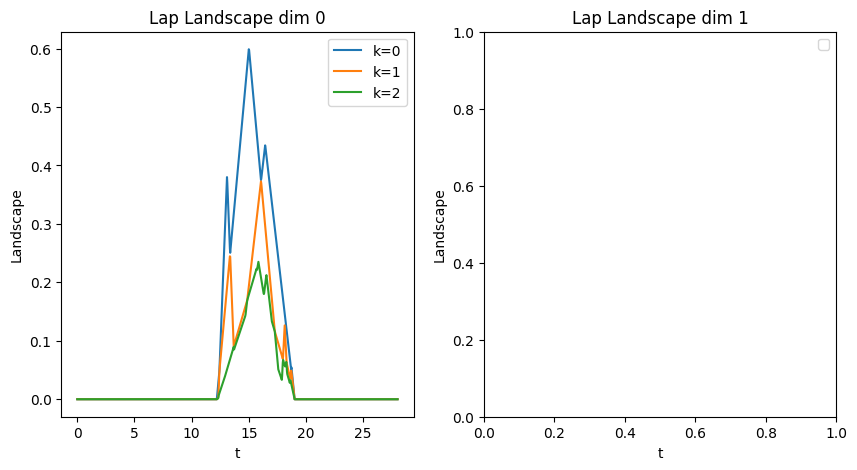

In [7]:
lap_land.plot()

In [18]:
np.argwhere(y == "9")[:10]

array([[19],
       [23],
       [33],
       [37],
       [49],
       [52],
       [54],
       [61],
       [70],
       [86]])

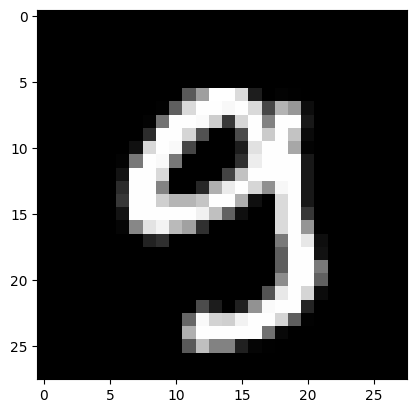

In [26]:
from PIL import Image
id_image = 19
# Image.fromarray((X[id_image]).astype(np.uint8)).convert("L").save("../figures/mnist_9.png")
plt.imshow(X[id_image], cmap="gray")

In [16]:
# f = filtration_from_image(np_array=X[3], cover = CubicalCover(10, overlap_frac=0.4, algorithm="standard"), cluster_algorithm=DBSCAN(eps=2, min_samples=2), use_y_as_color=True, use_new_filtration=False)#, save_to_html="ballmapper_filtration_mnist_8.html")
# f = filtration_from_image(np_array=X[id_image], mapper_1d = True, cover = CubicalCover(n_intervals=8, overlap_frac=0.23, algorithm="standard"), cluster_algorithm=DBSCAN(eps=1.5, min_samples=2), use_y_as_color=True, use_new_filtration=False)#, save_to_html="ballmapper_filtration_mnist_8.html")
f =  filtration_from_image_ballmapper(np_array=X[id_image], eps=3, use_new_filtration=False, use_y_as_color=True)#, save_to_html="../figures/mnist_6_ballmapper_eps_5_ada.html")
# draw_filtration(f, show=False)
# plt.savefig("../figures/mnist_6_ballmapper_eps_3_filtratoin.png", dpi=300, bbox_inches="tight")
# f

array([<Axes: title={'center': 'Landscape dim 0'}, xlabel='t', ylabel='Landscape'>,
       <Axes: title={'center': 'Landscape dim 1'}, xlabel='t', ylabel='Landscape'>],
      dtype=object)

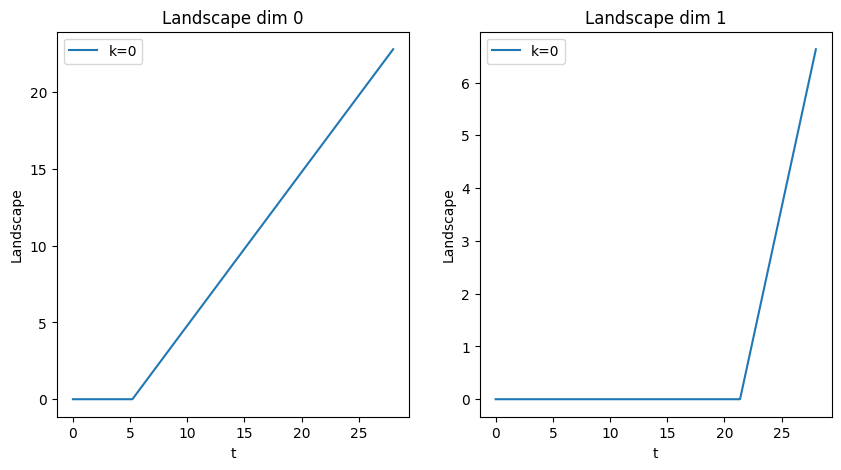

In [17]:
Landscape(f, max_t=28, use_infinite=True).plot()#.show_diagram()
# plt.savefig("../figures/mnist_6_ballmapper_eps_3_pers_landscape.png", dpi=300, bbox_inches="tight")

Computing boundary matrices:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

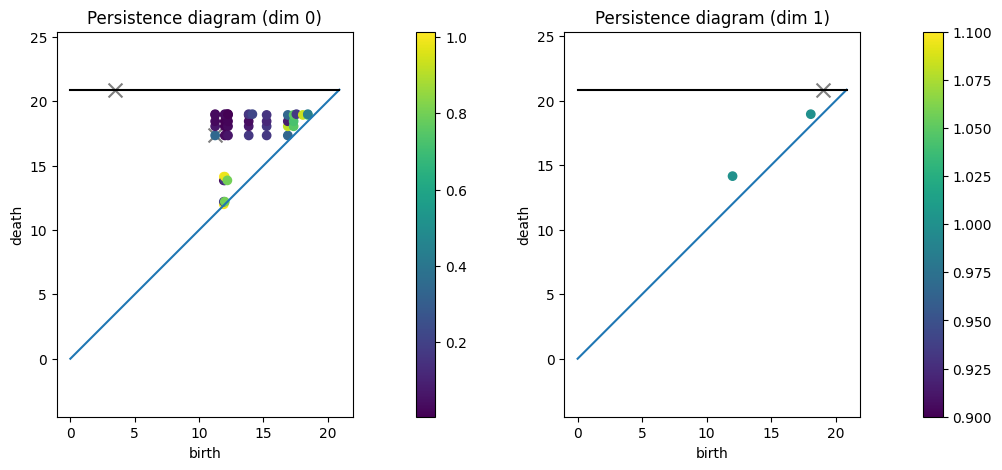

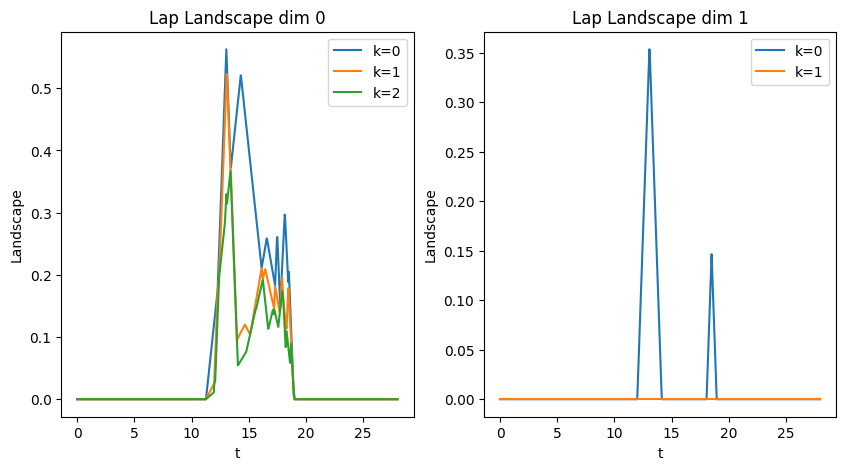

In [63]:
Lap_Landscape(f, Laplacian_fun=Laplacian_fun, max_t=28).plot()#limits=[[0, 28, 0, 1], [0, 28, 0, 0.2]])
# plt.savefig("../figures/mnist_6_ballmapper_eps_3_mult_landscape.png", dpi=300, bbox_inches="tight")

In [95]:
from Laplacian_Functions import compute_Laplacian

out_vec = []
boundary_matrices, name_to_idx, simplices_at_time, relevant_times = compute_boundary_matrices(f, lambda _ : 1, device = "cpu")
for q in range(2):
    for s in range(29):
        for t in range(s, 29):
            # print(q, s, t)
            t_i = np.argmin(np.abs(relevant_times - t))
            s_i = np.argmin(np.abs(relevant_times - s))
            # Lap = cross_Laplacian(q, boundary_matrices, s_i, t_i, simplices_at_time, relevant_times, verb=False, Laplacian_fun = Laplacian_fun, device="cpu")
            Lap = persistent_Laplacian_filtration(q, boundary_matrices, relevant_times[s_i], relevant_times[t_i], simplices_at_time, verb=False)
            eigs = np.linalg.eigvalsh(Lap)
            eigs = eigs[eigs > 1e-10]
            if len(eigs) > 0:
                out_vec.append(np.min(eigs))
                # out_vec.append(np.sum(eigs))
            else:
                out_vec.append(0)
out_vec[243]

Computing boundary matrices:   0%|          | 0/64 [00:00<?, ?it/s]

0.5857864376269054

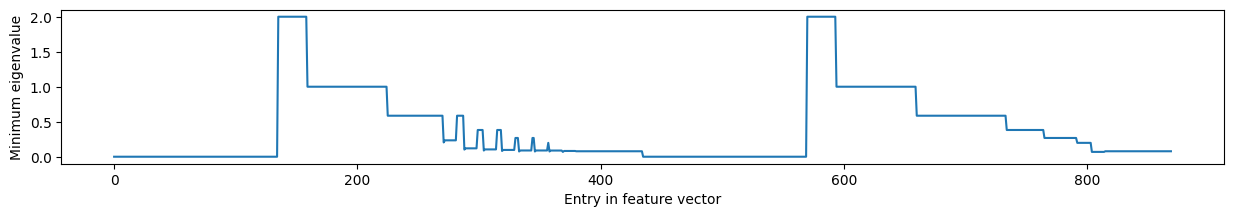

In [97]:
fig = plt.figure(figsize=(15,2))
plt.plot(out_vec)
# plt.figsize((4, 4))
plt.xlabel("Entry in feature vector")
plt.ylabel("Minimum eigenvalue")
plt.savefig("../figures/mnist_report/mnist_6_ballmapper_eps_3_pers_lap_min_eigenvalue.png", dpi=300, bbox_inches="tight")

Computing boundary matrices:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating projection matrices...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Calculating Laplacians and eigenvalues...


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

/home/siroj/code/Master_thesis/code/Laplacian_Functions_torch.py:958: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


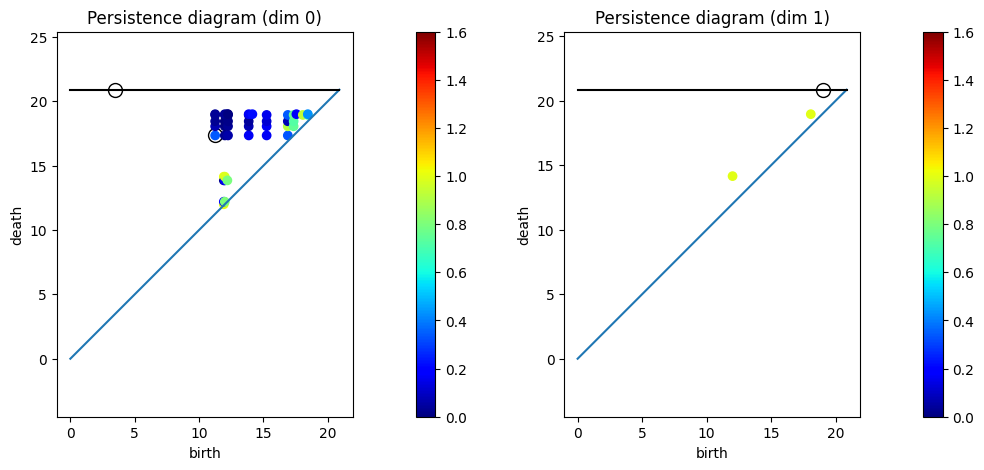

In [74]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    # return B22_sm1t@B22_stm1-B22_st
    # return B22_stm1@B22_sm1t-B22_st

    # Normal
    return -1*(B22_sm1tm1 - B22_sm1t - B22_stm1 + B22_st)

    # Horizontal
    # return B22_stm1 - B22_st

    # Vertical
    # return B22_sm1t - B22_st

#eigenvalues, relevant_times, fig, ax, _ =     
_ = plot_Laplacian_new_eigenvalues(f, lambda x: 1, 
                                        compute_only_trace=False, 
                                        max_dim =1, 
                                        device="cpu", 
                                        plot_diagram= True, 
                                        plot_types=["Min eigenvalue", "Max eigenvalue", "Sum of eigenvalues", "Amount of non-zero eigenvalues"], 
                                        Laplacian_fun= Laplacian_fun, 
                                        method="greville", 
                                        plot_args_diag={"c": "white", "alpha": 1, "marker": "o", "edgecolor": "black"}, 
                                        plot_type_to_fun={"Amount of non-zero eigenvalues": (len, True), "Betti numbers": (lambda x: np.count_nonzero(x<1e-10), False)}, 
                                        integer_time_steps=True,
                                        lap_pt_style={"cmap": "jet", "vmin": 0, "vmax": 1.6})

In [79]:
s, t = 12, 14.5

t_i = np.argmin(np.abs(relevant_times - t))
s_i = np.argmin(np.abs(relevant_times - s))
cross_Laplacian(q, boundary_matrices, s_i, t_i, simplices_at_time, relevant_times, verb=False, Laplacian_fun = Laplacian_fun, device="cpu")

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.3333, -0.3333,  0.3333],
        [ 0.0000,  0.0000,  0.0000, -0.3333,  0.3333, -0.3333],
        [ 0.0000,  0.0000,  0.0000,  0.3333, -0.3333,  0.3333]])

In [67]:
test_vec = np.load("../mnist_ballmapper_vectors/sample_size_7000/eps_3/color_x/6/mult_image_3.npy")

FileNotFoundError: [Errno 2] No such file or directory: '../mnist_ballmapper_vectors/sample_size_7000/eps_3/color_x/6/mult_image_3.npy'

In [13]:
len(test_vec)

870

In [ ]:
for q i

870

In [ ]:
for i in range(29)

0.44293231772223307

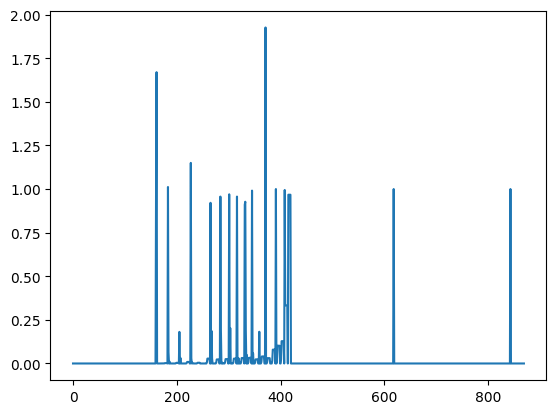

In [7]:
plt.plot(test_vec)

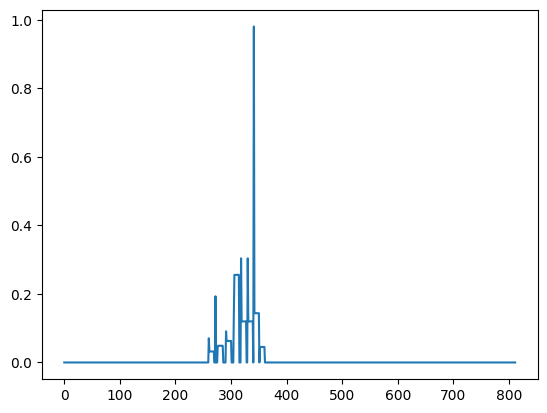

In [26]:
plt.plot(out_vec)

In [54]:
f.remove_node(0)

In [57]:
{i: f.nodes()[i]["ids"] for i in (f.nodes())}

{28: [0, 2, 4],
 27: [1, 3, 5],
 26: [4, 6, 9],
 25: [5, 7, 10],
 24: [8, 11, 14],
 23: [9, 12, 15],
 22: [10, 13, 16],
 21: [14, 18, 22],
 20: [15, 19, 23],
 19: [16, 20, 24],
 17: [17, 21, 25, 29],
 18: [17, 21],
 16: [18, 22, 26, 30],
 15: [19, 23, 27, 31],
 14: [20, 24, 28, 32],
 13: [25, 29, 33, 36],
 12: [26, 30, 34, 37],
 11: [27, 31, 35, 38],
 10: [28, 32],
 9: [33, 36, 39],
 8: [34, 37, 40],
 7: [35, 38, 41],
 6: [39, 42, 45],
 5: [40, 43, 46],
 4: [41, 44],
 3: [45, 47, 49],
 2: [46, 48, 50],
 1: [49, 51, 53]}

(55, 2)


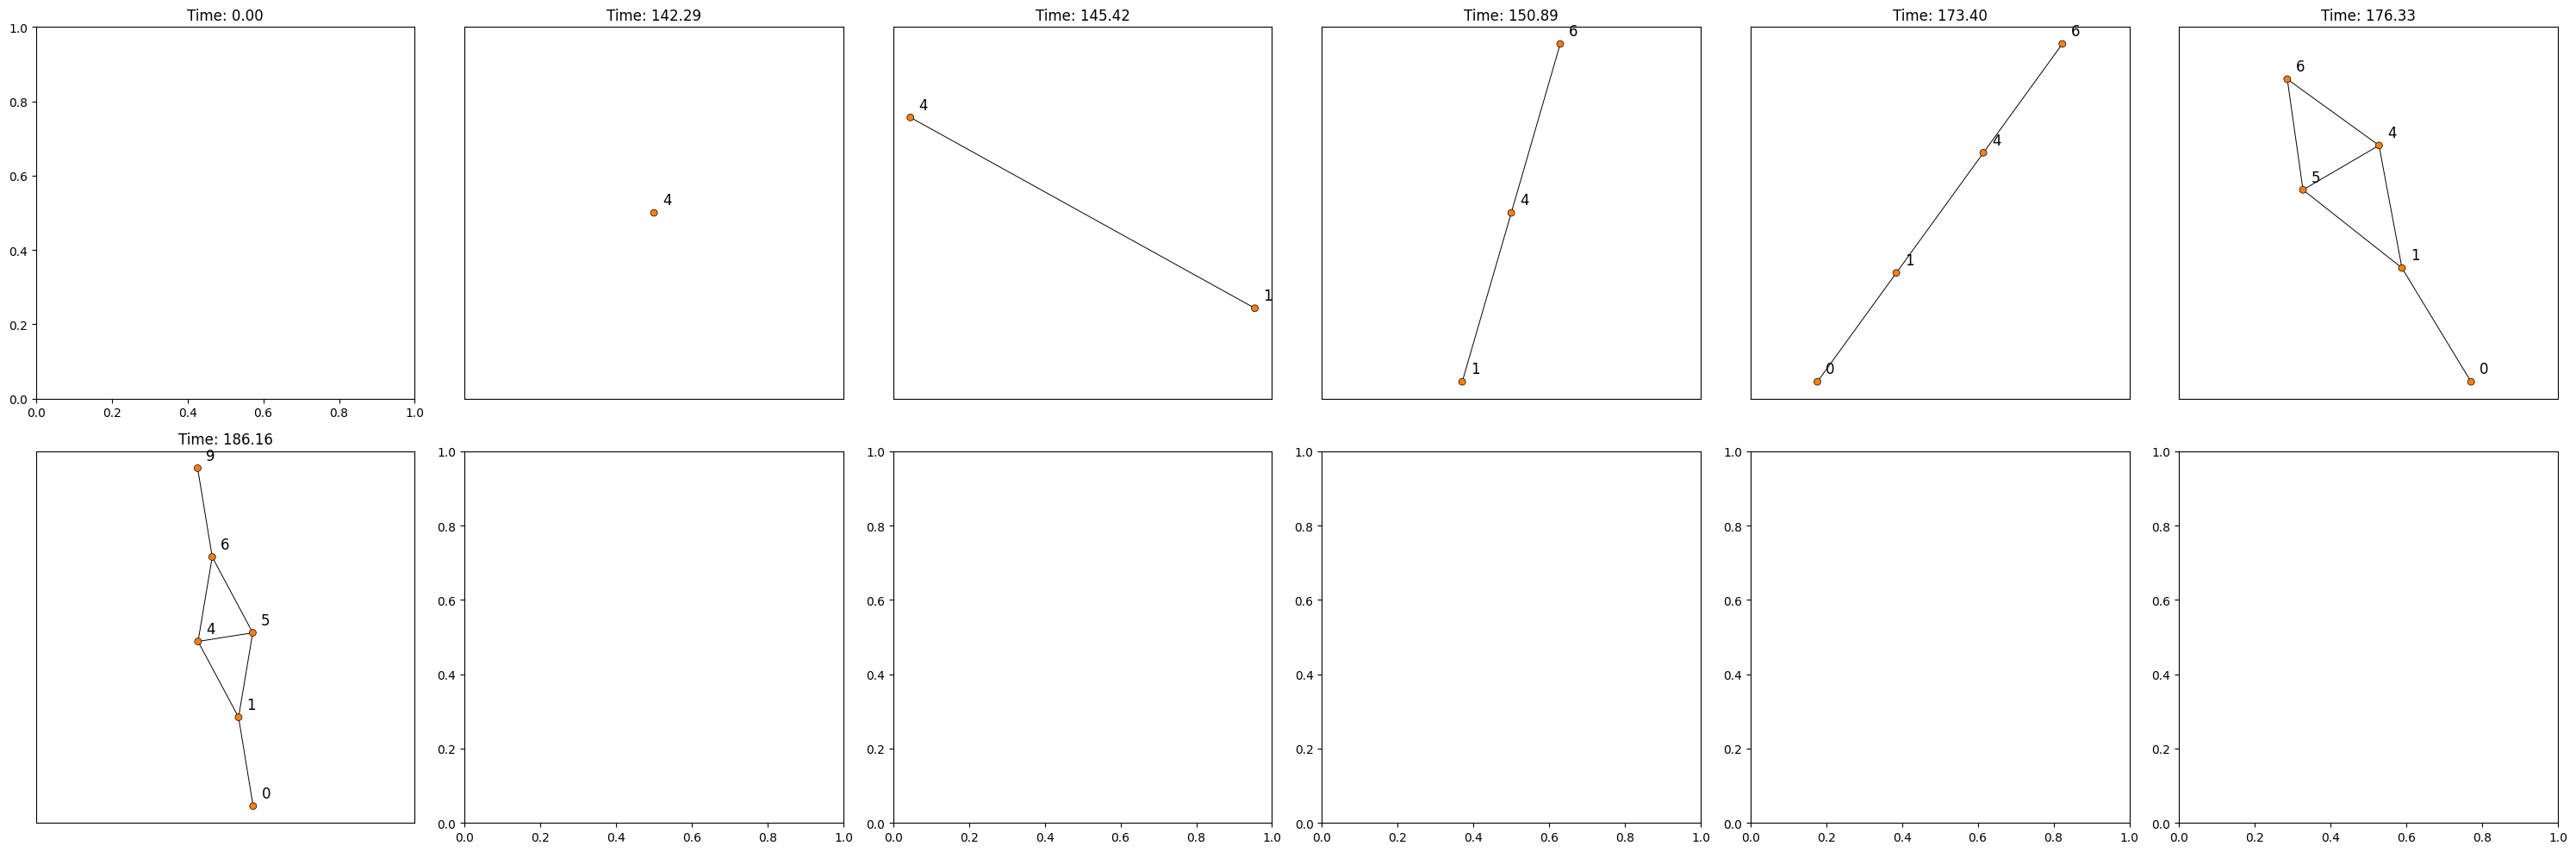

In [26]:
f = filtration_from_image_ballmapper(np_array=X[6], eps=2, use_new_filtration=True)
draw_filtration(f)

In [ ]:
X_1 = np.vstack(np.where(X[4]>1)).T
max_y = np.max(X_1[:,0])
y_1 = max_y-X_1[:,0]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X_1[:,1], -X_1[:,0], c=y_1, cmap="Reds")
lens = (y_1-np.min(y_1))/(np.max(y_1)-np.min(y_1))
fig.show()

In [ ]:
X_1 = np.vstack(np.where(X[4]>1)).T
bm = BallMapper(X=X_1.astype(np.float64), eps=3, coloring_df=pd.DataFrame(max_y-X_1[:, 0], columns=["y"])) #coloring_df = pd.DataFrame(y, columns=["y"]))
bm.draw_networkx(coloring_variable="y")